In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as tpl
import torch

In [2]:
from scipy.special import gamma
from scipy.linalg import expm, sqrtm, logm
from scipy.stats import multivariate_normal as mv_norm
from scipy.stats import invwishart, chi2

%matplotlib inline

In [3]:
# Make inline plots vector graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

#matplotlib.rc("font", **{"family": "serif", "serif": ["Times Roman"]})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

In [4]:
#helper functions
def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("Psi matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)
    
def my_kron_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n2 + l] = A[i,k] * B[j,l]
    
    return(K)
    
def my_box_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n1 + l] = A[i,l] * B[j,k]
    
    return(K)

def my_box(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n1 + l] = A[i,l] * B[j,k]
    
    return(K)

# return a cut through a 2D psd_cone, given values for the 
# a_11 and a_22 position of the matrix and a constant rho
def make_2D_psd_cone_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        is_pos_def(matrix)
        xx.append(matrix)
        
    return(xx)

def make_2D_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        xx.append(matrix)
        
    return(xx)

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def create_spd_matrix(p=2, eps=10e-3):
    
    #create two symmetric positive-definite matrices
    X_ = torch.rand(p,p)
    X_sym = (X_ + X_.T)/2
    lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + eps
    X_spd = X_sym + torch.eye(p) * lambda_X_min
    print("X_spd is spd: ", is_pos_def(X_spd))
    
    return(X_spd.cpu().numpy())

    

(301, 2, 2)
(301,)


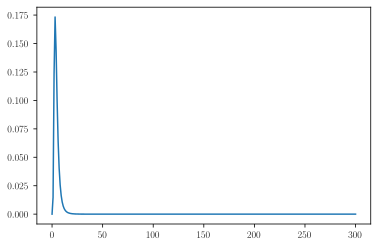

In [5]:
# test the make_2D_psd_cone_cut function
a_11 = np.linspace(0.1, 30.1, 300 +1)
a_22 = np.linspace(0.1, 60.1, 300 +1)
rho = 0

s = np.array([[4,2],
             [2,3]])
is_pos_def(s)

xx = make_2D_psd_cone_cut(a_11, a_22, rho)

w = []
print(np.shape(xx))
for x in xx:
    w_ = invwishart.pdf(x, df=4, scale=s)
    w.append(w_)
print(np.shape(w))

plt.plot(w);
plt.show()

# Inverse Wishart Bridge

Set up the approximations in standard and transformed base and create plots for the bridge.

In [6]:
"""functions"""

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def inverse_wishart_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2))
    rest = np.linalg.det(X)**(-(v+p+1)/2) * np.exp(-1/2*np.trace(Psi @ np.linalg.inv(X)))
    return(const * rest)

def inverse_wishart_t_logm_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2))
    rest =  np.linalg.det(expm(X))**(-(v+p-1)/2) * np.exp(-0.5*np.trace(Psi @ np.linalg.inv(expm(X))))
    return(const * rest)

def inverse_wishart_t_sqrtm_pdf(X, v, Psi):
    p = np.shape(X)[0]
    const = np.linalg.det(Psi)**(v/2)/(2**(v*p/2) * multi_variate_gamma(p, v/2)) * p**2 
    rest =  np.linalg.det(X)**(-(v+p)) * np.exp(-0.5*np.trace(Psi @ np.linalg.inv(X.T@X)))
    return(const * rest)

def inverse_wishart_mu(nu, p, Psi):
    r = 1/(nu+p+1)*Psi
    return(r.reshape(p,p))

def inverse_wishart_Sigma(nu, p, Psi):
    vp1 = nu + p +1
    R = 2/(vp1)**3 * np.kron(Psi, Psi)
    return(R)

def multivariate_normal_pdf_test(X, mu, Sigma):
    k = np.shape(X)[0]
    a = (2*np.pi)**(-k/2) * np.linalg.det(Sigma)**(-1/2)
    x_mu = (X-mu).reshape(-1)
    b = np.exp(-1/2 * x_mu.T @ np.linalg.inv(Sigma) @ x_mu)
    return(a*b)

def make_Gamma(n):
    
    Gamma = np.zeros((n**2, n**2))
    I = np.eye(n)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    Gamma[i*n +j, k*n + l] = 1/2 * (I[i,k]*I[j,l] + I[i,l]*I[j,k])
    
    return(Gamma)

def make_U(n):
    G = make_Gamma(n)
    eig_values, eig_vectors = np.linalg.eig(G)
    U = []
    #print(eig_vectors, eig_values)
    for i, v in enumerate(eig_values):
        if v == 1:
            U.append(eig_vectors[i])

    U = np.array(U)
    return(U)

def multivariate_normal_pdf_test_sym(X, mu, Sigma_inv):
    
    k = np.shape(X)[0]
    correction = (1/2*k*(k+1))/k**2 
    a = -k/2 * np.log(2*np.pi)
    U = make_U(2)
    b = 1/2*np.log(np.linalg.det(U@Sigma_inv@U.T))
    #b = 1/2*np.log(np.linalg.det(Sigma_inv)) 
    x_mu = (X-mu).reshape(-1)
    c = -1/2 * x_mu.T @ Sigma_inv @ x_mu
    return(correction * np.exp(a+b+c))

"""Transformation: logm"""

def inverse_wishart_t_logm_mu(nu, p, Psi):
    r =  logm(1/(nu+p-1) * Psi)
    return(r.reshape(p,p))

def inverse_wishart_t_logm_Sigma(nu, p, Psi):
    return(2/(nu + p - 1) * np.eye(p**2))

def inverse_wishart_t_logm_Sigma_inv(nu, p, Psi):
    return((nu + p - 1)/2 * np.eye(p**2))

def log_mv_normal_back(X, mu, Sigma):
    X_ = logm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(np.linalg.inv(X)))
    
"""Transformation: sqrtm"""

def inverse_wishart_t_sqrtm_mu(nu, p, Psi):
    r =  sqrtm(1/(nu+p)*Psi)
    return(r.reshape(p,p))

def kronecker(A, B):
    return(torch.einsum("ij,kl->ikjl", A, B).reshape(A.size(0)*B.size(0),  A.size(1)*B.size(1)))


def inverse_wishart_t_sqrtm_Sigma(nu, p, Psi):
    
    Psi = torch.Tensor(Psi)
    Psi_inv = torch.inverse(Psi)
    Psi_sqrtm = torch.Tensor(sqrtm(Psi.detach().numpy()))
    Psi_inv_sqrtm = torch.inverse(Psi_sqrtm)
    one = kronecker(torch.eye(p), Psi)
    two = torch.inverse((kronecker(Psi_sqrtm, Psi_inv_sqrtm) + torch.eye(p**2)))
    R = 1/(nu + p)**2 * one @ two
    
    return(R.detach().numpy()) 

def inverse_wishart_t_sqrtm_Sigma_inv(nu, p, Psi):
    
    Psi_inv = np.linalg.inv(Psi)
    Psi_sqrtm = sqrtm(Psi)
    Psi_sqrtm_inv = sqrtm(Psi_inv)
    
    c = (nu + p)**2
    one = np.kron(Psi, Psi_inv) + np.kron(Psi_sqrtm, Psi_sqrtm_inv)
    two = np.kron(Psi_sqrtm_inv, Psi_sqrtm_inv)
    R = c * one @ two
    return(R)
    
def sqrt_mv_normal_back(X, mu, Sigma):
    X_ = sqrtm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(sqrtm(X)))


In [7]:
n1 = 4
p1 = 2
Psi1 = np.array([[3,2], [2, 4]])

Sigma_sqrtm = inverse_wishart_t_sqrtm_Sigma(n1, p1, Psi1)
Sigma_sqrtm_inv = inverse_wishart_t_sqrtm_Sigma_inv(n1, p1, Psi1)
Sigma_logm = inverse_wishart_t_logm_Sigma(n1, p1, Psi1)
Sigma_logm_inv = inverse_wishart_t_logm_Sigma_inv(n1, p1, Psi1)

print(Sigma_sqrtm)
print(np.linalg.inv(Sigma_sqrtm_inv))
print(Sigma_logm)
print(np.linalg.inv(Sigma_logm_inv))

[[ 0.04605603  0.03655651 -0.00658405 -0.00438937]
 [ 0.03655651  0.0643343  -0.00438936 -0.00877873]
 [-0.00658405 -0.00438937  0.042764    0.03436182]
 [-0.00438936 -0.00877873  0.03436182  0.05994492]]
[[ 0.04605603  0.03655651 -0.00658405 -0.00438937]
 [ 0.03655651  0.06433429 -0.00438937 -0.00877873]
 [-0.00658405 -0.00438937  0.04276401  0.03436183]
 [-0.00438937 -0.00877873  0.03436183  0.05994492]]
[[0.4 0.  0.  0. ]
 [0.  0.4 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.  0.  0.  0.4]]
[[0.4 0.  0.  0. ]
 [0.  0.4 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.  0.  0.  0.4]]


# logm Bridge

In [8]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_inverse_Wishart_bridge_logm(xx, xxt, ns, s, p=2, save=False, filename='', show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = inverse_wishart_mu(n1, p=p, Psi=s)
    mode2 = inverse_wishart_mu(n2, p=p, Psi=s)
    mode3 = inverse_wishart_mu(n3, p=p, Psi=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = inverse_wishart_Sigma(n1, p=p, Psi=s)
    sigma2 = inverse_wishart_Sigma(n2, p=p, Psi=s)
    sigma3 = inverse_wishart_Sigma(n3, p=p, Psi=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    iw1 = []
    iw2 = []
    iw3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        iw_1 = inverse_wishart_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_pdf(X=x, v=n3, Psi=s)
        iw1.append(iw_1)
        iw2.append(iw_2)
        iw3.append(iw_3)
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(iw1_lpa)
        normal2.append(iw2_lpa)
        normal3.append(iw3_lpa)

    iw1 = np.array(iw1)
    iw2 = np.array(iw2)
    iw3 = np.array(iw3)
    
    rescale_normal1 = np.max(iw1)/np.max(normal1)
    rescale_normal2 = np.max(iw2)/np.max(normal2)
    rescale_normal3 = np.max(iw3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    
    ######### logm transformation

    mode1_t_logm = inverse_wishart_t_logm_mu(n1, p=p, Psi=s)
    mode2_t_logm = inverse_wishart_t_logm_mu(n2, p=p, Psi=s)
    mode3_t_logm = inverse_wishart_t_logm_mu(n3, p=p, Psi=s)

    sigma1_t_logm = inverse_wishart_t_logm_Sigma(n1, p=p, Psi=s)
    sigma2_t_logm = inverse_wishart_t_logm_Sigma(n2, p=p, Psi=s)
    sigma3_t_logm = inverse_wishart_t_logm_Sigma(n3, p=p, Psi=s)

    is_pos_def(sigma1_t_logm)
    is_pos_def(sigma2_t_logm)
    is_pos_def(sigma3_t_logm)

    iw1_t_logm = []
    iw2_t_logm = []
    iw3_t_logm = []
    iw1_lpa_t_logm = []
    iw2_lpa_t_logm = []
    iw3_lpa_t_logm = []

    for x in xxt:
        iw_1 = inverse_wishart_t_logm_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_t_logm_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_t_logm_pdf(X=x, v=n3, Psi=s)
        iw1_t_logm.append(iw_1)
        iw2_t_logm.append(iw_2)
        iw3_t_logm.append(iw_3)
        #
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_logm, Sigma=sigma1_t_logm)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_logm, Sigma=sigma2_t_logm)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_logm, Sigma=sigma3_t_logm)
        iw1_lpa_t_logm.append(iw1_lpa)
        iw2_lpa_t_logm.append(iw2_lpa)
        iw3_lpa_t_logm.append(iw3_lpa)

    #rescale for visibility
    iw1_t_logm = np.array(iw1_t_logm)
    iw2_t_logm = np.array(iw2_t_logm)
    iw3_t_logm = np.array(iw3_t_logm)
    
    rescale1_t_logm = np.max(iw1_t_logm)/np.max(iw1_lpa_t_logm)
    rescale2_t_logm = np.max(iw2_t_logm)/np.max(iw2_lpa_t_logm)
    rescale3_t_logm = np.max(iw3_t_logm)/np.max(iw3_lpa_t_logm)

    iw1_lpa_t_logm = np.array(iw1_lpa_t_logm) * rescale1_t_logm
    iw2_lpa_t_logm = np.array(iw2_lpa_t_logm) * rescale2_t_logm
    iw3_lpa_t_logm = np.array(iw3_lpa_t_logm) * rescale3_t_logm

    ######### back transform #########

    iw1_back = []
    iw2_back = []
    iw3_back = []

    for x in xx:
        iw1_back.append(log_mv_normal_back(x, mode1_t_logm, sigma1_t_logm))
        iw2_back.append(log_mv_normal_back(x, mode2_t_logm, sigma2_t_logm))
        iw3_back.append(log_mv_normal_back(x, mode3_t_logm, sigma3_t_logm))
        
    rescale_back1 = np.max(iw1)/np.max(iw1_back)
    rescale_back2 = np.max(iw2)/np.max(iw2_back)
    rescale_back3 = np.max(iw3)/np.max(iw3_back)

    iw1_back = np.array(iw1_back) * rescale_back1
    iw2_back = np.array(iw2_back) * rescale_back2 
    iw3_back = np.array(iw3_back) * rescale_back3 
    
    """Plots"""
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 15
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=16
    lw = 2

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(10, 3))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(10, 3))
        
    axs[0].plot(iw1, 'r-', lw=lw)
    axs[0].plot(iw2, 'b-', lw=lw)
    axs[0].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size})

    axs[1].plot(iw1_t_logm, 'r', lw=lw)
    axs[1].plot(iw2_t_logm, 'b', lw=lw)
    axs[1].plot(iw3_t_logm, 'k', lw=lw, label="$\mathcal{IW}$")
    axs[1].plot(iw1_lpa_t_logm, 'r--', lw=lw)
    axs[1].plot(iw2_lpa_t_logm, 'b--', lw=lw)
    axs[1].plot(iw3_lpa_t_logm, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in logm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size})

    if show_back:
        axs[2].plot(iw1, 'r-', lw=lw)
        axs[2].plot(iw2, 'b-', lw=lw)
        axs[2].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$");
        axs[2].plot(iw1_back, 'r--', lw=lw)
        axs[2].plot(iw2_back, 'b--', lw=lw)
        axs[2].plot(iw3_back, 'k--', lw=lw, label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show();

[[4 2]
 [2 3]]
(301, 2, 2)


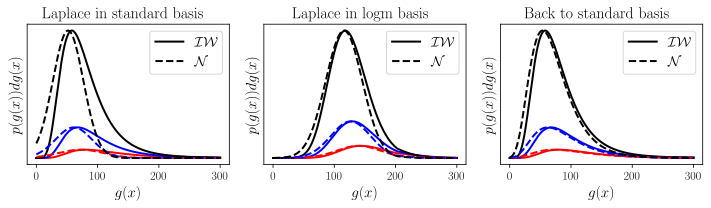

In [9]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 1.5, 300 +1)
a_22 = np.linspace(0.1, 1.5, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 2*np.eye(2)

#s = create_spd_matrix(eps=3)
print(s)

is_pos_def(s)

a_11_t = np.linspace(-2.3, 1.1, 300 +1)
a_22_t = np.linspace(-2.3, 1.1, 300 +1)

r = 0.5
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_cut(a_11_t, a_22_t, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_inverse_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=True,
                                 filename='inverse_wishart_logm_bridge.pdf', show_back=True)

-0.9
(301, 2, 2)


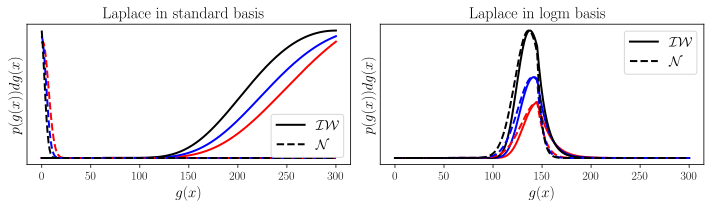

-0.8
(301, 2, 2)


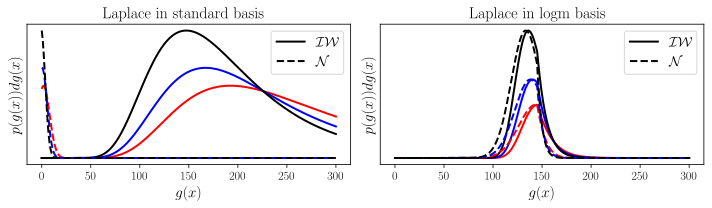

-0.7
(301, 2, 2)


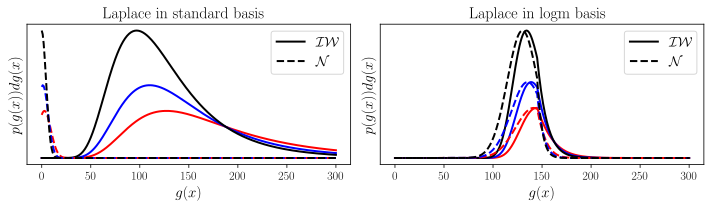

-0.6
(301, 2, 2)


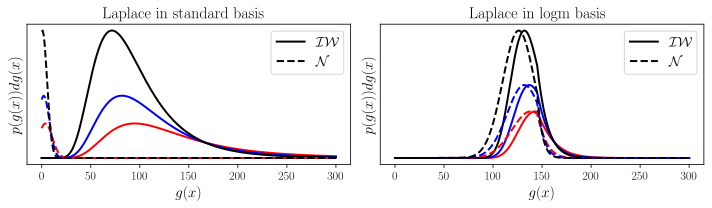

-0.5
(301, 2, 2)


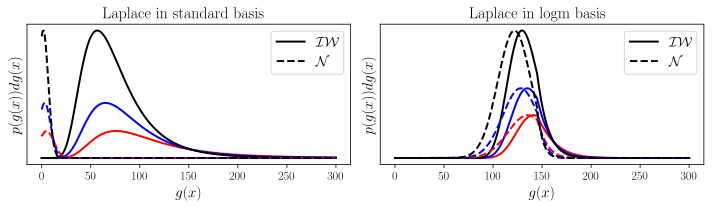

-0.4
(301, 2, 2)


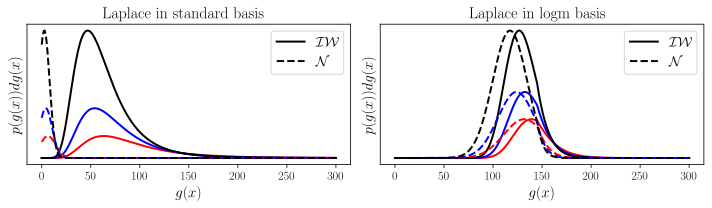

-0.29999999999999993
(301, 2, 2)


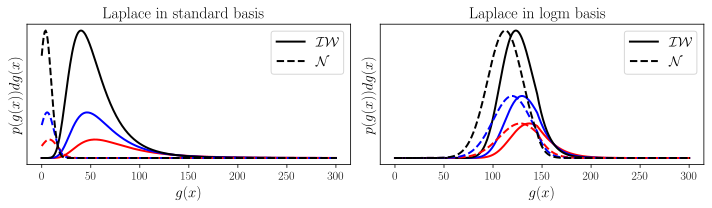

-0.19999999999999996
(301, 2, 2)


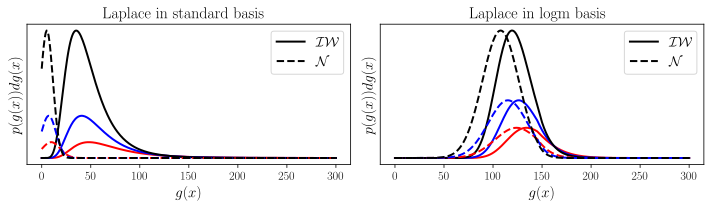

-0.09999999999999998
(301, 2, 2)


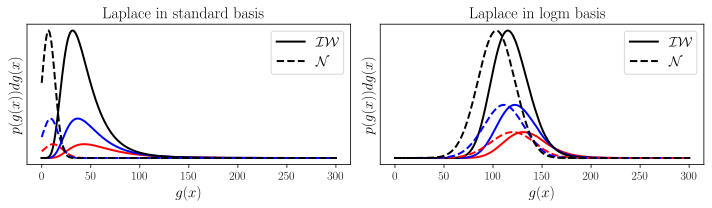

0.0
(301, 2, 2)


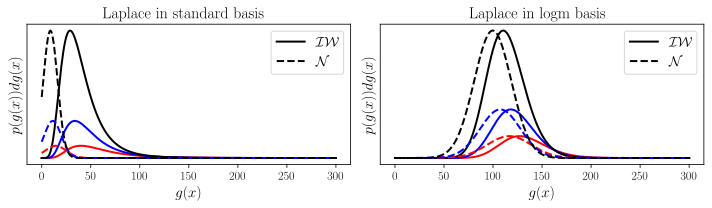

0.09999999999999998
(301, 2, 2)


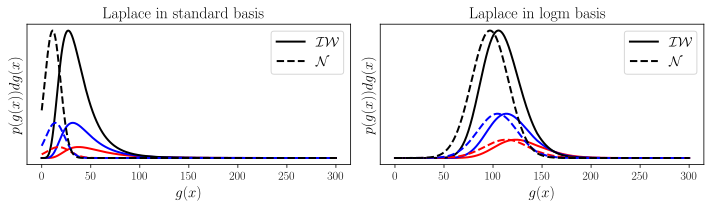

0.20000000000000007
(301, 2, 2)


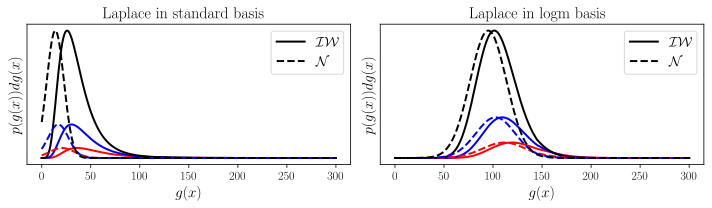

0.30000000000000016
(301, 2, 2)


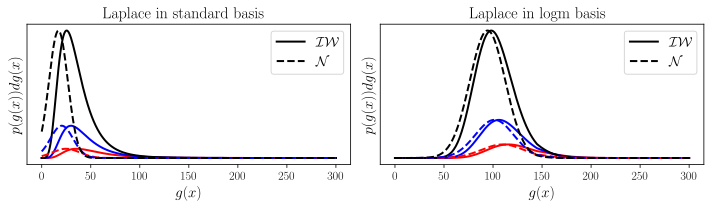

0.4
(301, 2, 2)


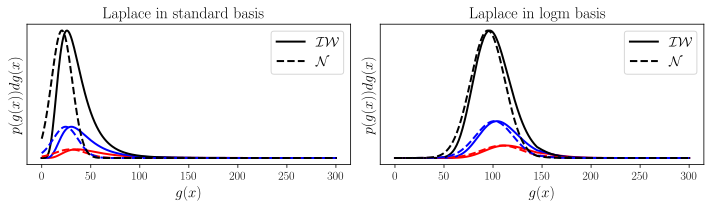

0.5000000000000001
(301, 2, 2)


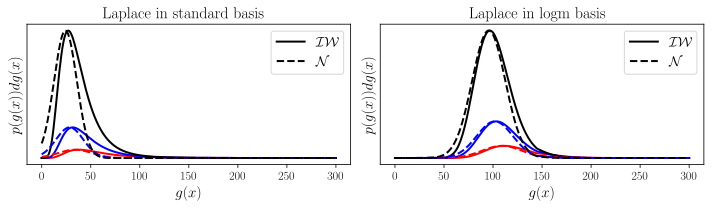

0.6
(301, 2, 2)


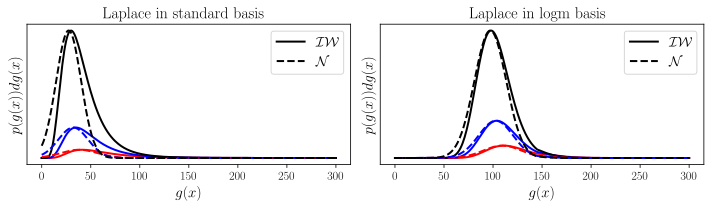

0.7000000000000001
(301, 2, 2)


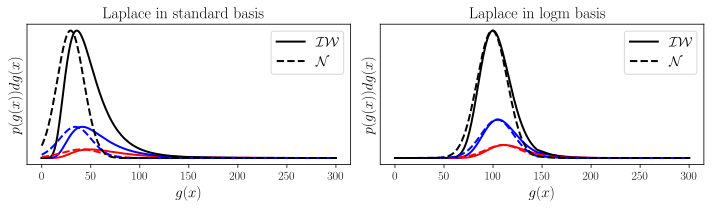

0.8000000000000002
(301, 2, 2)


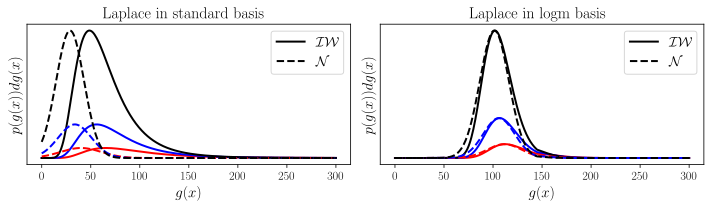

0.9
(301, 2, 2)


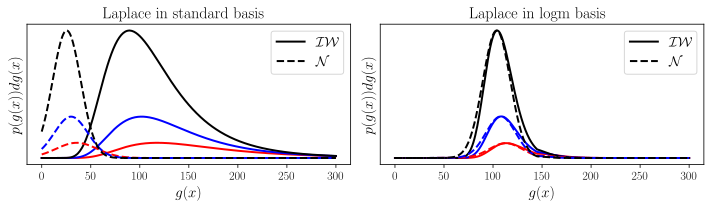

In [10]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

#s = np.array([[4,2],
#             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

a_11 = np.linspace(0.1, 3.1, 300 +1)
a_22 = np.linspace(0.1, 3.1, 300 +1)

a_11_t = np.linspace(-2.9, 3.1, 300 +1)
a_22_t = np.linspace(-2.9, 3.1, 300 +1)


is_pos_def(s)

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_cut(a_11_t, a_22_t, r)
    plot_inverse_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, show_back=False)

# sqrtm Bridge

In [11]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_inverse_Wishart_bridge_sqrtm(xx, xxt, ns, s, p=2, save=False, filename='', show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = inverse_wishart_mu(n1, p=p, Psi=s)
    mode2 = inverse_wishart_mu(n2, p=p, Psi=s)
    mode3 = inverse_wishart_mu(n3, p=p, Psi=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = inverse_wishart_Sigma(n1, p=p, Psi=s)
    sigma2 = inverse_wishart_Sigma(n2, p=p, Psi=s)
    sigma3 = inverse_wishart_Sigma(n3, p=p, Psi=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    iw1 = []
    iw2 = []
    iw3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        iw_1 = inverse_wishart_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_pdf(X=x, v=n3, Psi=s)
        iw1.append(iw_1)
        iw2.append(iw_2)
        iw3.append(iw_3)
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(iw1_lpa)
        normal2.append(iw2_lpa)
        normal3.append(iw3_lpa)

    iw1 = np.array(iw1)
    iw2 = np.array(iw2)
    iw3 = np.array(iw3)
    
    rescale_normal1 = np.max(iw1)/np.max(normal1)
    rescale_normal2 = np.max(iw2)/np.max(normal2)
    rescale_normal3 = np.max(iw3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    
    ######### sqrtm transformation

    mode1_t_sqrtm = inverse_wishart_t_sqrtm_mu(n1, p=p, Psi=s)
    mode2_t_sqrtm = inverse_wishart_t_sqrtm_mu(n2, p=p, Psi=s)
    mode3_t_sqrtm = inverse_wishart_t_sqrtm_mu(n3, p=p, Psi=s)

    sigma1_t_sqrtm = inverse_wishart_t_sqrtm_Sigma(n1, p=p, Psi=s)
    sigma2_t_sqrtm = inverse_wishart_t_sqrtm_Sigma(n2, p=p, Psi=s)
    sigma3_t_sqrtm = inverse_wishart_t_sqrtm_Sigma(n3, p=p, Psi=s)

    is_pos_def(sigma1_t_sqrtm)
    is_pos_def(sigma2_t_sqrtm)
    is_pos_def(sigma3_t_sqrtm)

    iw1_t_sqrtm = []
    iw2_t_sqrtm = []
    iw3_t_sqrtm = []
    iw1_lpa_t_sqrtm = []
    iw2_lpa_t_sqrtm = []
    iw3_lpa_t_sqrtm = []

    for x in xxt:
        iw_1 = inverse_wishart_t_sqrtm_pdf(X=x, v=n1, Psi=s)
        iw_2 = inverse_wishart_t_sqrtm_pdf(X=x, v=n2, Psi=s)
        iw_3 = inverse_wishart_t_sqrtm_pdf(X=x, v=n3, Psi=s)
        iw1_t_sqrtm.append(iw_1)
        iw2_t_sqrtm.append(iw_2)
        iw3_t_sqrtm.append(iw_3)
        #
        iw1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_sqrtm, Sigma=sigma1_t_sqrtm)
        iw2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_sqrtm, Sigma=sigma2_t_sqrtm)
        iw3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_sqrtm, Sigma=sigma3_t_sqrtm)
        iw1_lpa_t_sqrtm.append(iw1_lpa)
        iw2_lpa_t_sqrtm.append(iw2_lpa)
        iw3_lpa_t_sqrtm.append(iw3_lpa)

    #rescale for visibility
    iw1_t_sqrtm = np.array(iw1_t_sqrtm)
    iw2_t_sqrtm = np.array(iw2_t_sqrtm)
    iw3_t_sqrtm = np.array(iw3_t_sqrtm)
    
    rescale1_t_sqrtm = np.max(iw1_t_sqrtm)/np.max(iw1_lpa_t_sqrtm)
    rescale2_t_sqrtm = np.max(iw2_t_sqrtm)/np.max(iw2_lpa_t_sqrtm)
    rescale3_t_sqrtm = np.max(iw3_t_sqrtm)/np.max(iw3_lpa_t_sqrtm)

    iw1_lpa_t_sqrtm = np.array(iw1_lpa_t_sqrtm) * rescale1_t_sqrtm
    iw2_lpa_t_sqrtm = np.array(iw2_lpa_t_sqrtm) * rescale2_t_sqrtm
    iw3_lpa_t_sqrtm = np.array(iw3_lpa_t_sqrtm) * rescale3_t_sqrtm

    ######### back transform #########

    iw1_back = []
    iw2_back = []
    iw3_back = []

    for x in xx:
        iw1_back.append(log_mv_normal_back(x, mode1_t_sqrtm, sigma1_t_sqrtm))
        iw2_back.append(log_mv_normal_back(x, mode2_t_sqrtm, sigma2_t_sqrtm))
        iw3_back.append(log_mv_normal_back(x, mode3_t_sqrtm, sigma3_t_sqrtm))
        
    rescale_back1 = np.max(iw1)/np.max(iw1_back)
    rescale_back2 = np.max(iw2)/np.max(iw2_back)
    rescale_back3 = np.max(iw3)/np.max(iw3_back)

    iw1_back = np.array(iw1_back) * rescale_back1
    iw2_back = np.array(iw2_back) * rescale_back2 
    iw3_back = np.array(iw3_back) * rescale_back3 

    """Plots"""
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 15
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=16
    lw = 2

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(10, 3))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(10, 3))
        
    axs[0].plot(iw1, 'r-', lw=lw)
    axs[0].plot(iw2, 'b-', lw=lw)
    axs[0].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size})

    axs[1].plot(iw1_t_sqrtm, 'r', lw=lw)
    axs[1].plot(iw2_t_sqrtm, 'b', lw=lw)
    axs[1].plot(iw3_t_sqrtm, 'k', lw=lw, label="$\mathcal{IW}$")
    axs[1].plot(iw1_lpa_t_sqrtm, 'r--', lw=lw)
    axs[1].plot(iw2_lpa_t_sqrtm, 'b--', lw=lw)
    axs[1].plot(iw3_lpa_t_sqrtm, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in sqrtm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size})

    if show_back:
        axs[2].plot(iw1, 'r-', lw=lw)
        axs[2].plot(iw2, 'b-', lw=lw)
        axs[2].plot(iw3, 'k-', lw=lw, label="$\mathcal{IW}$");
        axs[2].plot(iw1_back, 'r--', lw=lw)
        axs[2].plot(iw2_back, 'b--', lw=lw)
        axs[2].plot(iw3_back, 'k--', lw=lw, label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show();

[[4 2]
 [2 3]]
(301, 2, 2)


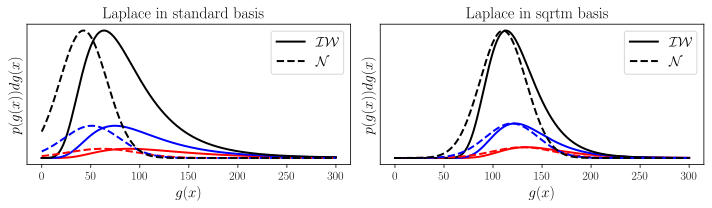

In [12]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 1.3, 300 +1)
a_22 = np.linspace(0.1, 1.3, 300 +1)

a_11_t = np.linspace(0.1, 1.5, 300 +1)
a_22_t = np.linspace(0.1, 1.5, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 0.5*np.eye(2)

#s = create_spd_matrix(eps=3)
print(s)

is_pos_def(s)

r = 0.3
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_cut(a_11_t, a_22_t, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_inverse_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=True,
                                  filename='inverse_wishart_sqrtm_bridge.pdf', show_back=False)


-0.9
(301, 2, 2)


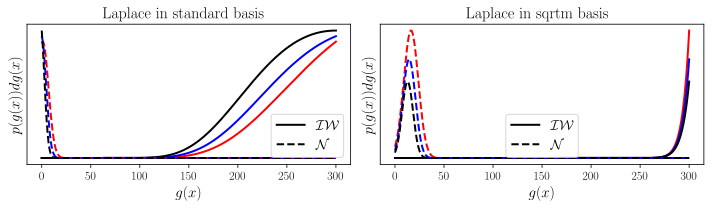

-0.8
(301, 2, 2)


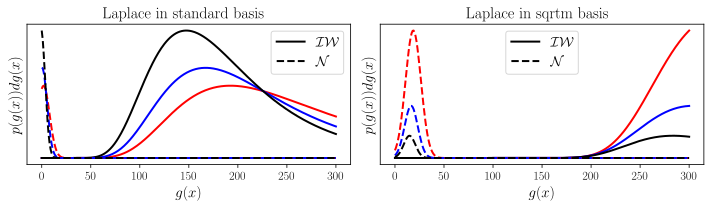

-0.7
(301, 2, 2)


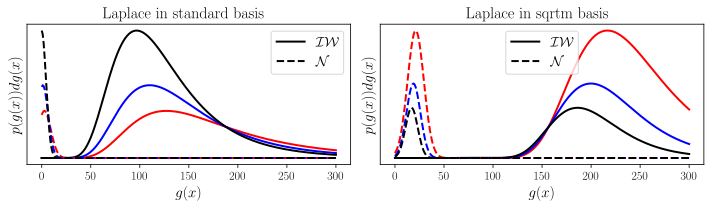

-0.6
(301, 2, 2)


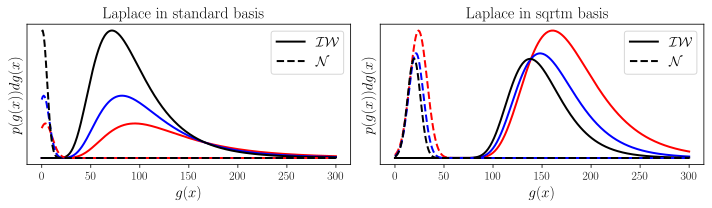

-0.5
(301, 2, 2)


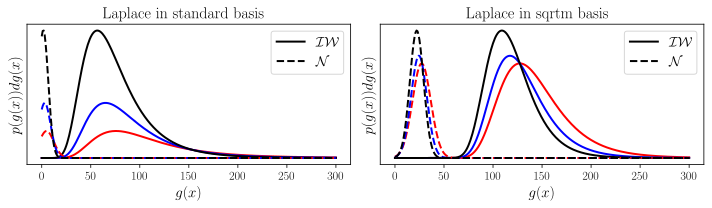

-0.4
(301, 2, 2)


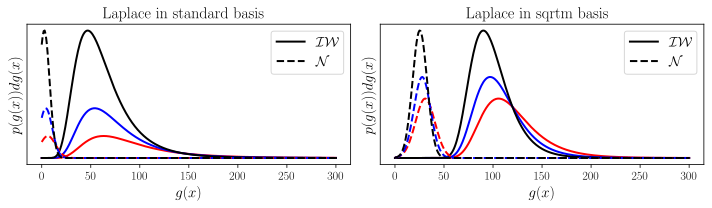

-0.29999999999999993
(301, 2, 2)


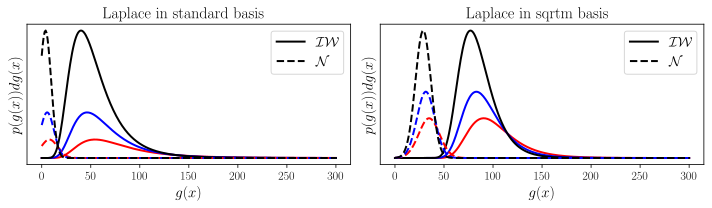

-0.19999999999999996
(301, 2, 2)


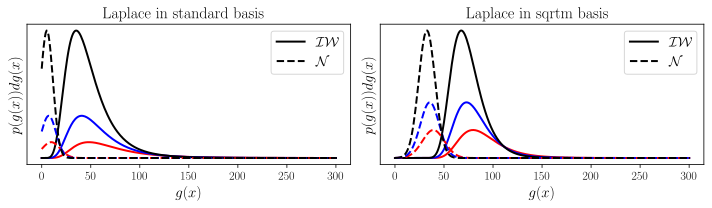

-0.09999999999999998
(301, 2, 2)


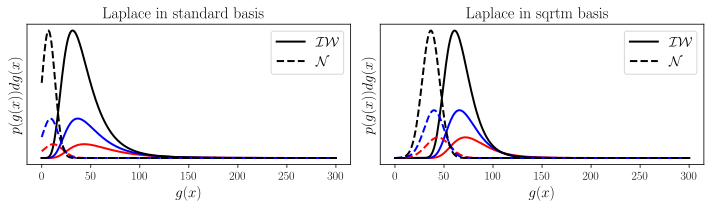

0.0
(301, 2, 2)


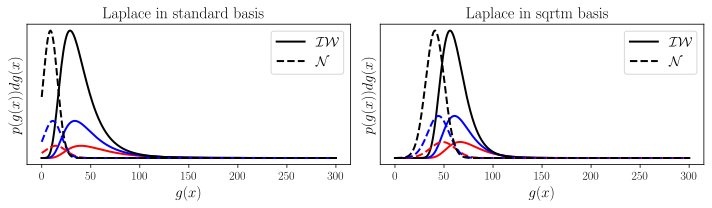

0.09999999999999998
(301, 2, 2)


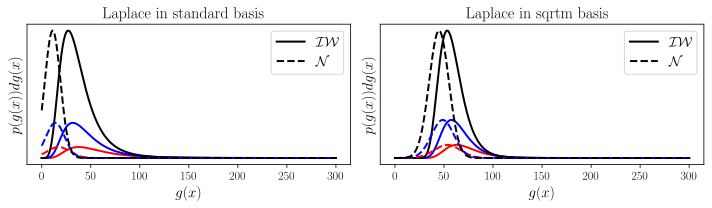

0.20000000000000007
(301, 2, 2)


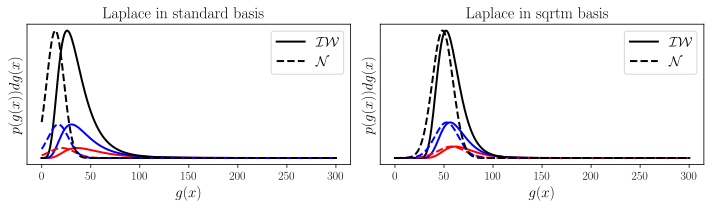

0.30000000000000016
(301, 2, 2)


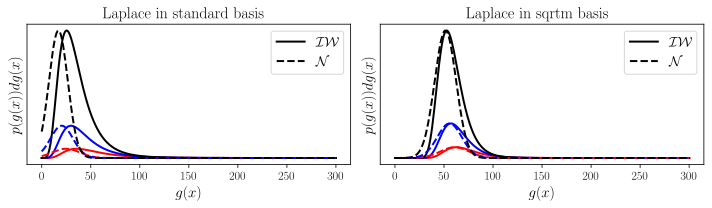

0.4
(301, 2, 2)


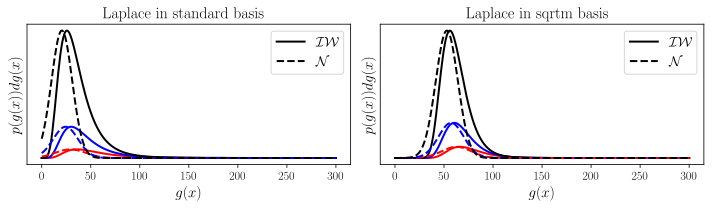

0.5000000000000001
(301, 2, 2)


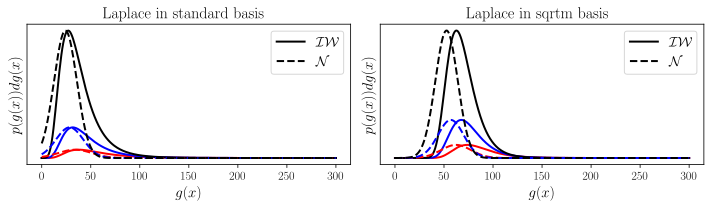

0.6
(301, 2, 2)


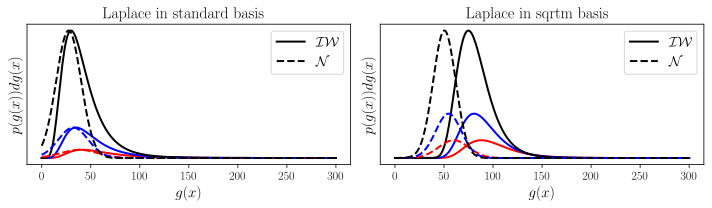

0.7000000000000001
(301, 2, 2)


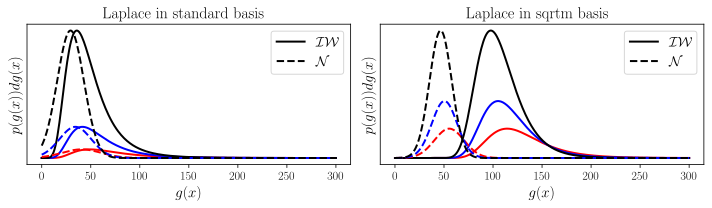

0.8000000000000002
(301, 2, 2)


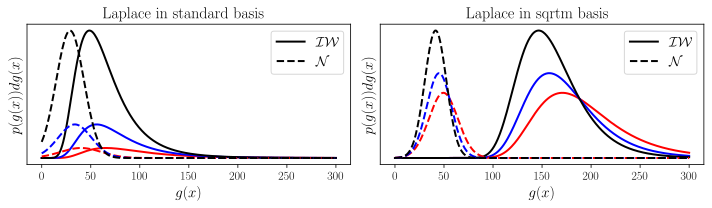

0.9
(301, 2, 2)


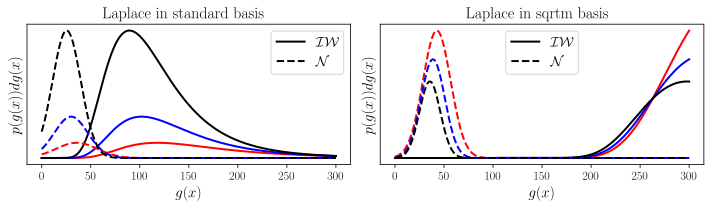

In [13]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

is_pos_def(s)

n1 = 4
n2 = 5
n3 = 6

p=2

a_11 = np.linspace(0.1, 3.1, 300 +1)
a_22 = np.linspace(0.1, 3.1, 300 +1)

a_11_t = np.linspace(0.1, 3.1, 300 +1)
a_22_t = np.linspace(0.1, 3.1, 300 +1)

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_cut(a_11_t, a_22_t, r)
    plot_inverse_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, show_back=False)

# Statistical distance measures

Compare the Laplace approximation of the Distribution in different bases to ensure we actually improve it. We use mean maximum discrepancy (MMD) and KL-divergence as metrics.

In [14]:
from torch_two_sample import MMDStatistic
from scipy.stats import invwishart
from scipy.stats import multivariate_normal as mv_norm
import torch

## starting with MMD for 25 pairs of parameters

In [15]:
def MMD_combinations(params, plot=False, n_samples=1000, verbose=True):
    
    Ns = params[0]
    Vs = params[1]
    p = np.shape(Vs[0])[0]
    
    MMD_sum = 0
    MMD_t_logm_sum = 0 
    MMD_t_sqrtm_sum = 0 

    for n in Ns:
        for v in Vs:
            
            if verbose:
                print("n: ", n, "V: ", v)

            if n <= p +1 :
                print("n <= p + 1 doesn't yield a Laplace Approximation in standard basis")

            #get samples from all dists
            #standard
            IW_samples = invwishart.rvs(n, v, size=n_samples)
            if n > p + 1:         
                mode1 = inverse_wishart_mu(n, p, v).reshape(-1)
                Sigma1 = inverse_wishart_Sigma(n, p, v)
                N_samples = mv_norm.rvs(mode1, Sigma1, size=n_samples)

            #logm
            mode1_logm = inverse_wishart_t_logm_mu(n, p, v).reshape(-1)
            Sigma1_logm = inverse_wishart_t_logm_Sigma(n, p, v)
            IW_samples_logm = np.array([logm(iw) for iw in IW_samples])
            N_samples_logm = mv_norm.rvs(mode1_logm, Sigma1_logm, size=n_samples)
            
            
            #sqrtm
            mode1_sqrtm = inverse_wishart_t_sqrtm_mu(n, p, v).reshape(-1)
            Sigma1_sqrtm = inverse_wishart_t_sqrtm_Sigma(n, p, v)
            IW_samples_sqrtm = np.array([sqrtm(iw) for iw in IW_samples])
            N_samples_sqrtm = mv_norm.rvs(mode1_sqrtm, Sigma1_sqrtm, size=n_samples)


            #calculate MMD for all bases
            MMD = MMDStatistic(n_samples, n_samples)

            #standard
            IW_samples_ = torch.Tensor(IW_samples.reshape((n_samples, -1)))
            if n > p + 1:         
                N_samples_ = torch.Tensor(N_samples.reshape((n_samples, -1)))
                MMD_ = MMD(IW_samples_, N_samples_,  alphas=[0.5], ret_matrix=False)
                MMD_ = torch.max(torch.zeros(1), MMD_)
            else:
                MMD_ = torch.Tensor([np.nan])

            #logm
            IW_samples_logm_ = torch.Tensor(IW_samples_logm.reshape((n_samples, -1)))
            N_samples_logm_ = torch.Tensor(N_samples_logm.reshape((n_samples, -1)))
            MMD_logm_= MMD(IW_samples_logm_, N_samples_logm_,  alphas=[0.5], ret_matrix=False)
            MMD_logm_= torch.max(torch.zeros(1), MMD_logm_)
            
            #sqrtm
            IW_samples_sqrtm_ = torch.Tensor(IW_samples_sqrtm.reshape((n_samples, -1)))
            N_samples_sqrtm_ = torch.Tensor(N_samples_sqrtm.reshape((n_samples, -1)))
            MMD_sqrtm_= MMD(IW_samples_sqrtm_, N_samples_sqrtm_,  alphas=[0.5], ret_matrix=False)
            MMD_sqrtm_= torch.max(torch.zeros(1), MMD_sqrtm_)

            if plot:
                rhos = np.linspace(-0.9, 0.9, 19)
                a_11 = np.linspace(0.1, 3.1, 300 +1)
                a_22 = np.linspace(0.1, 3.1, 300 +1)

                a_11_t = np.linspace(-2.9, 3.1, 300 +1)
                a_22_t = np.linspace(-2.9, 3.1, 300 +1)
                
                print("Logm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    xxt = make_2D_cut(a_11_t, a_22_t, r)
                    plot_inverse_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n, n, n], s=v, p=2, save=False, filename='')

                print("Sqrtm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    xxt = make_2D_cut(a_11_t, a_22_t, r)
                    plot_inverse_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n, n, n], s=v, p=2, save=False, filename='')

            if verbose: 
                print("standard: ", MMD_.item(), "logm: ", MMD_logm_.item(), "sqrtm: ", MMD_sqrtm_.item())

            #add them to their respective sums
            MMD_sum += MMD_
            MMD_t_logm_sum += MMD_logm_
            MMD_t_sqrtm_sum += MMD_sqrtm_

    return(MMD_sum.item(), MMD_t_logm_sum.item(), MMD_t_sqrtm_sum.item())

In [16]:
np.random.seed(42)
random_Vs = [create_spd_matrix(p=3, eps=10e-3) for _ in range(5)]
MMD_combinations(params=[range(4,9), random_Vs], plot=False, verbose=True, n_samples=2000)

X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
n:  4 V:  [[0.62425053 0.47401857 0.59922886]
 [0.47401857 0.7423653  0.7770009 ]
 [0.59922886 0.7770009  0.86453336]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 4.888770845936246e-07
standard:  nan logm:  0.09841671586036682 sqrtm:  0.2613108158111572
n:  4 V:  [[0.8500103  0.54564345 0.6577586 ]
 [0.54564345 0.4253048  0.50777286]
 [0.6577586  0.50777286 0.63154256]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 4.957833441821801e-07
standard:  nan logm:  0.09898821264505386 sqrtm:  0.26505404710769653
n:  4 V:  [[0.8119188  0.56894267 0.24291751]
 [0.56894267 0.88442916 0.10832158]
 [0.24291751 0.10832158 0.77808595]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 3.2740761575

(nan, 2.7537143230438232, 3.473353862762451)

# KL div from samples, attempt 2

In [17]:
def KL_div_samples_invwishart2(n, V, num_samples, base='standard', plot=False):
    
    invwishart_samples = invwishart.rvs(n, V, size=num_samples)
    bin_size = int(num_samples**0.25)
    assert(base in ['standard', 'logm', 'sqrtm'])
    
    p = V[0].shape[0]
    eps = 1e-15
    
    if base == 'logm':
    
        invwishart_samples_logm = np.array([logm(s) for s in invwishart_samples]).reshape(num_samples, -1)
        mu_invwishart_logm = inverse_wishart_t_logm_mu(n, p, V).reshape(-1)
        #Sigma_invwishart_logm = inverse_wishart_t_logm_Sigma(n, p, V)
        Sigma_invwishart_logm_inv = inverse_wishart_t_logm_Sigma_inv(n, p, V)
        
        s = np.array(invwishart_samples_logm).reshape(num_samples, p, p)
        p_ = np.array([inverse_wishart_t_logm_pdf(s_, n, V) for s_ in s])
        s = s.reshape(num_samples, -1)
        #q_ = mv_norm.pdf(s, mu_invwishart_logm, Sigma_invwishart_logm)
        q_ = np.array([multivariate_normal_pdf_test_sym(x_, mu_invwishart_logm, Sigma_invwishart_logm_inv) for x_ in s])
        KL_div_logm_ = np.mean(np.log(p_ +1e-8) - np.log(q_ +1e-8))
        
        if plot:
            pass

        return(KL_div_logm_)
    
    elif base == 'sqrtm':
    
        invwishart_samples_sqrtm = np.array([sqrtm(s) for s in invwishart_samples]).reshape(num_samples, -1)
        mu_invwishart_sqrtm = inverse_wishart_t_sqrtm_mu(n, p, V).reshape(-1)
        #Sigma_invwishart_sqrtm = inverse_wishart_t_sqrtm_Sigma(n, p, V)
        Sigma_invwishart_sqrtm_inv = inverse_wishart_t_sqrtm_Sigma_inv(n, p, V)
        
        s = np.array(invwishart_samples_sqrtm).reshape(num_samples, p, p)
        p_ = np.array([inverse_wishart_t_sqrtm_pdf(s_, n, V) for s_ in s])
        s = s.reshape(num_samples, -1)
        #q_ = mv_norm.pdf(s, mu_invwishart_sqrtm, Sigma_invwishart_sqrtm)
        q_ = np.array([multivariate_normal_pdf_test_sym(x_, mu_invwishart_sqrtm, Sigma_invwishart_sqrtm_inv) for x_ in s])
        KL_div_sqrtm_ = np.mean(np.log(p_ + 1e-8) - np.log(q_ + 1e-8))
        
        if plot:
            pass

        return(KL_div_sqrtm_)
    
    elif base == 'standard':
    
        invwishart_samples = invwishart_samples.reshape(num_samples, -1)
        mu_invwishart = inverse_wishart_mu(n, p, V).reshape(-1)
        Sigma_invwishart = inverse_wishart_Sigma(n, p, V)
        
        s = np.array(invwishart_samples).reshape(num_samples, p, p)
        p_ = np.array([inverse_wishart_pdf(s_, n, V) for s_ in s])
        s = s.reshape(num_samples, -1)
        q_ = mv_norm.pdf(s, mu_invwishart, Sigma_invwishart)
        KL_div_ = np.mean(np.log((p_ + 1e-8)/(q_+ 1e-8)))
        
        if plot:
            pass

        return(KL_div_)



In [18]:
def KL_div_samples_combinations2(params, num_samples, plot=False, verbose=True):
    
    KL_div_sum = 0
    KL_div_logm_sum = 0
    KL_div_sqrtm_sum = 0

    for Ps in params:
        
        n, V = Ps
        p = np.shape(V)[0]

        if verbose:
            print("n: ", n, "V: ", V, "p: ", p)

        if n <= p + 1:
            print("Wishart has no valid Laplace Approximation in standard base for n <= p+1")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_invwishart2(n, V, num_samples=num_samples, base='standard', plot=False)                
        KL_div_sum += KL_div_
            
        #compute KL-div for log base
        KL_div_logm_ = KL_div_samples_invwishart2(n, V, num_samples=num_samples, base='logm', plot=False)
        KL_div_logm_sum += KL_div_logm_
        
        #compute KL-div for log base
        KL_div_sqrtm_ = KL_div_samples_invwishart2(n, V, num_samples=num_samples, base='sqrtm', plot=False)
        KL_div_sqrtm_sum += KL_div_sqrtm_
        


        if verbose:
            print("standard: ", KL_div_, "logm: ", KL_div_logm_, "sqrtm: ", KL_div_sqrtm_)

    return(KL_div_sum, KL_div_logm_sum, KL_div_sqrtm_sum)

In [19]:
n1_test, V1_test = 2, np.eye(2)
n2_test, V2_test = 3, 2*np.eye(2)
n3_test, V3_test = 4, 3*np.eye(2)

invwishart_params = [[n1_test, V1_test], [n2_test, V2_test], [n3_test, V3_test]]

In [20]:
KL_div_samples_combinations2(invwishart_params, num_samples=10000)

n:  2 V:  [[1. 0.]
 [0. 1.]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  5.503060806386152 sqrtm:  9.87177228689377
n:  3 V:  [[2. 0.]
 [0. 2.]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  3.680822197536518 sqrtm:  8.067085813791769
n:  4 V:  [[3. 0.]
 [0. 3.]] p:  2
standard:  9.028560871424794 logm:  3.1036846439542565 sqrtm:  6.769376998868292


(nan, 12.287567647876926, 24.70823509955383)

# Compute KL divergence for increasing $\theta$

In [45]:
n_0, V_0 = 2, 0.5 * np.array([[1.5,1], [1,2]])
Ns = np.array([i*0.5 + n_0 for i in range(10)])
#Ns = np.array([1.5 + n_0 for i in range(10)])
#Vs = np.array([V_0 + 0.25*V_0*i for i in range(10)])
Vs = np.array([V_0 for i in range(10)])
NVs = list(zip(Ns, Vs))
print(NVs)

[(2.0, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (2.5, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (3.0, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (3.5, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (4.0, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (4.5, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (5.0, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (5.5, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (6.0, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (6.5, array([[0.75, 0.5 ],
       [0.5 , 1.  ]]))]


In [46]:
KL_results_linear = []

for s in range(1):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for nv_ in NVs:
        n_, v_ = nv_
        #print(n_, v_)
        KL_ = KL_div_samples_combinations2([[n_, v_]], verbose=True, num_samples=10000)
        print(KL_)
        results_seed.append(KL_)
    
    KL_results_linear.append(results_seed)

seed:  0
n:  2.0 V:  [[0.75 0.5 ]
 [0.5  1.  ]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  5.751445938690026 sqrtm:  10.40009547812135
(nan, 5.751445938690026, 10.40009547812135)
n:  2.5 V:  [[0.75 0.5 ]
 [0.5  1.  ]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  5.0488585880746255 sqrtm:  10.041751782269033
(nan, 5.0488585880746255, 10.041751782269033)
n:  3.0 V:  [[0.75 0.5 ]
 [0.5  1.  ]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  4.626869396806564 sqrtm:  9.359427113264958
(nan, 4.626869396806564, 9.359427113264958)
n:  3.5 V:  [[0.75 0.5 ]
 [0.5  1.  ]] p:  2
standard:  11.274180372216343 logm:  4.467703540114251 sqrtm:  8.643386618060559
(11.274180372216343, 4.467703540114251, 8.643386618060559)
n:  4.0 V:  [[0.75 0.5 ]
 [0.5  1.  ]] p:  2
standard:  10.77030201922011 logm:  4.425956637171274 sqrtm:  8.240636553

In [47]:
# handle the data
KL_results_linear = np.array(KL_results_linear)

# take the mean over the 10 seeds
KL_results_linear_mean = KL_results_linear.mean(0)
print(np.shape(KL_results_linear_mean))

(10, 3)


In [48]:
KL_results_linear_mean

array([[        nan,  5.75144594, 10.40009548],
       [        nan,  5.04885859, 10.04175178],
       [        nan,  4.6268694 ,  9.35942711],
       [11.27418037,  4.46770354,  8.64338662],
       [10.77030202,  4.42595664,  8.24063655],
       [10.50138033,  4.53208878,  7.83937604],
       [ 9.94086739,  4.8229197 ,  7.60586474],
       [ 9.71828715,  5.11089312,  7.55359068],
       [ 9.19916241,  5.48652199,  7.52547456],
       [ 9.07453055,  5.96313111,  7.60226905]])

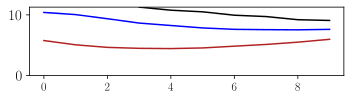

In [49]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(KL_results_linear_mean[:,0], label='standard base', color='black')
plt.plot(KL_results_linear_mean[:,1], label='logm base', color='firebrick')
plt.plot(KL_results_linear_mean[:,2], label='sqrtm base', color='blue')
plt.ylim(0, np.nanmax(KL_results_linear_mean))
plt.tight_layout()

#"""
tpl.save(
    "KL_inv_Wishart_n_inc_V_const.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=True,
    float_format=".3g"
)
#"""

#plt.savefig('KL_inv_Wishart.pdf')

plt.show();

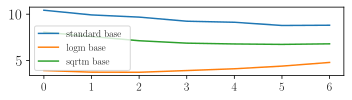

In [26]:
# make plots

plt.figure(figsize=(5, 1.5))
plt.plot(KL_results_linear_mean[3:,0], label='standard base')
plt.plot(KL_results_linear_mean[3:,1], label='logm base')
plt.plot(KL_results_linear_mean[3:,2], label='sqrtm base')
plt.legend()
plt.tight_layout()

plt.show();

# calculate MMD for growing ns and Vs and plot it

In [50]:
MMD_results_linear = []

for s in range(1):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for nv_ in NVs:
        n_, v_ = nv_
        MMD_ = MMD_combinations(params = [[n_], [v_]], n_samples=2000)
        print(MMD_)
        results_seed.append(MMD_)
    
    MMD_results_linear.append(results_seed)

seed:  0
n:  2.0 V:  [[0.75 0.5 ]
 [0.5  1.  ]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan logm:  0.11501657217741013 sqrtm:  0.41401001811027527
(nan, 0.11501657217741013, 0.41401001811027527)
n:  2.5 V:  [[0.75 0.5 ]
 [0.5  1.  ]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan logm:  0.1045490950345993 sqrtm:  0.2855970859527588
(nan, 0.1045490950345993, 0.2855970859527588)
n:  3.0 V:  [[0.75 0.5 ]
 [0.5  1.  ]]
n <= p + 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan logm:  0.10217159986495972 sqrtm:  0.20526957511901855
(nan, 0.10217159986495972, 0.20526957511901855)
n:  3.5 V:  [[0.75 0.5 ]
 [0.5  1.  ]]
standard:  0.23415285348892212 logm:  0.09093564748764038 sqrtm:  0.14077967405319214
(0.23415285348892212, 0.09093564748764038, 0.14077967405319214)
n:  4.0 V:  [[0.75 0.5 ]
 [0.5  1.  ]]
standard:  0.17641586065292358 logm:  0.09152692556381226 sqrtm:  0.10868746042251587
(0.176415

In [51]:
# handle the data
MMD_results_linear = np.array(MMD_results_linear)

# take the mean over the 10 seeds
MMD_results_linear_mean = MMD_results_linear.mean(0)
print(np.shape(MMD_results_linear_mean))

(10, 3)


In [52]:
MMD_results_linear_mean

array([[       nan, 0.11501657, 0.41401002],
       [       nan, 0.1045491 , 0.28559709],
       [       nan, 0.1021716 , 0.20526958],
       [0.23415285, 0.09093565, 0.14077967],
       [0.17641586, 0.09152693, 0.10868746],
       [0.13551819, 0.08781257, 0.0841102 ],
       [0.10871601, 0.08518031, 0.06984478],
       [0.07700461, 0.08152103, 0.05194414],
       [0.05457926, 0.07911393, 0.03834093],
       [0.04176927, 0.06860104, 0.03033549]])

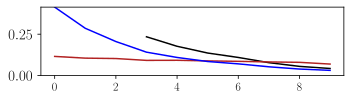

In [53]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(MMD_results_linear_mean[:,0], label='standard base', color='black')
plt.plot(MMD_results_linear_mean[:,1], label='logm base', color='firebrick')
plt.plot(MMD_results_linear_mean[:,2], label='sqrtm base', color='blue')
plt.ylim(0, np.nanmax(MMD_results_linear_mean))
plt.tight_layout()

#"""
tpl.save(
    "MMD_inv_Wishart_n_inc_V_const.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=True,
    float_format=".3g"
)
#"""

#plt.savefig('MMD_inv_Wishart.pdf')

plt.show();